In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray
import json

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

import dataclasses
import navier_stokes
from navier_stokes import NavierStokes2D2
from make_forcing import Forcings

Forced Turbulence Simulations
Uses settings defined in spectral.equations.ForcedNavierStokes2D

In [2]:
%%time 

# physical parameters
viscosity = 1e-2
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .1, viscosity, grid)
img = f"/Users/carsonmcvay/desktop/gradschool/research/turbulence_encryption/raw_images/image_3.jpg"
wave_number = 1
offsets = ((0, 0), (0, 0))
forcing_fun = lambda grid: Forcings().mod_kolmogorov_forcing(img,grid, k=wave_number, offsets=offsets)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing 


# **use predefined settings for Kolmogorov flow**
# this is where I need to change ForcedNavierStokes2D
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    # original line
    # spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt)
    navier_stokes.ForcedNavierStokes2D2(viscosity, grid, smooth=smooth, forcing_fn=forcing_fun), dt)


# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

Inside mod_kolmogorov_forcing - img_path: /Users/carsonmcvay/desktop/gradschool/research/turbulence_encryption/raw_images/image_3.jpg (type: <class 'str'>)
grid (type: <class 'jax_cfd.base.grids.Grid'>)
CPU times: user 7min 38s, sys: 1min 39s, total: 9min 17s
Wall time: 3min 10s


In [3]:
# debugging
print("Trajectory shape:", trajectory.shape)
print("Trajectory min value:", jnp.min(trajectory))
print("Trajectory max value:", jnp.max(trajectory))
print("Trajectory contains NaN:", jnp.isnan(trajectory).any())


Trajectory shape: (10, 256, 129)
Trajectory min value: (-164973.61-50488.72j)
Trajectory max value: (278990.75-107949.65j)
Trajectory contains NaN: False


Summary of debugging:
There are issues with the trajectory, leading to NaN values. It appears that the forcing function is operating properly, and the simulation has the correct shape. 
The NaNs are likely due to a numerical instability, which I will now attempt to debug.

It turns out it was the timestep. I made it smaller and things got better.

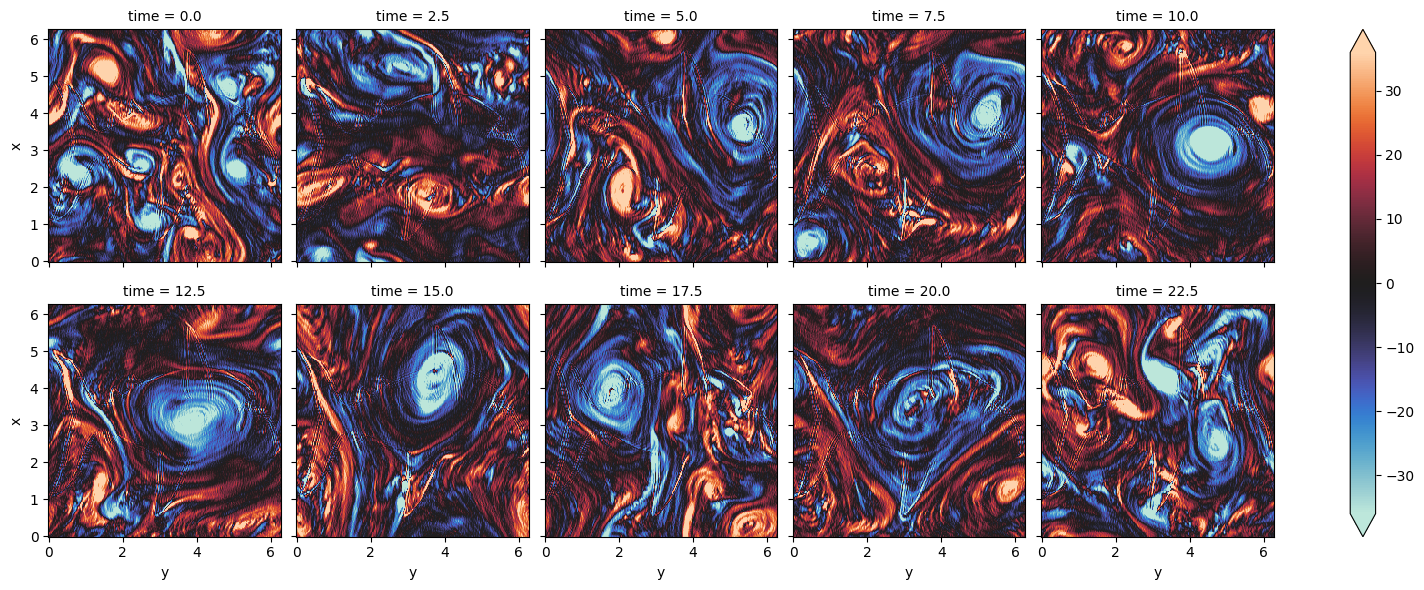

In [8]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)), 
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

In [9]:
# find snapshot closest to t=15 
# might change the time

timestep_index = jnp.abs(coords['time']-12.5).argmin()
simulation_at_t15 = trajectory[timestep_index]


In [17]:
print("trajectory contains NaN:", jnp.isnan(simulation_at_t15).any())

trajectory contains NaN: False


In [16]:
# save forcing function
navier_stokes_model = navier_stokes.ForcedNavierStokes2D2(viscosity, grid, smooth=smooth, forcing_fn=forcing_fun)

# Generate velocity components as GridVariable objects
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vx, vy = v0  # Assuming `v0` provides x and y velocity components
vx_grid_var = navier_stokes._get_grid_variable(vx.data, grid)
vy_grid_var = navier_stokes._get_grid_variable(vy.data, grid)

# Evaluate the pre-initialized forcing function with the grid variables
forcing_fn_with_grid = navier_stokes_model._forcing_fn_with_grid
forcing_x, forcing_y = forcing_fn_with_grid((vx_grid_var, vy_grid_var))
# added check for NaNs in forcing fn outputs
print("NaNs in forcing_x:", jnp.isnan(forcing_x.data).sum())
print("NaNs in forcing_y:", jnp.isnan(forcing_y.data).sum())

# # evaluate the forcing fn to get components
# forcing_field = forcing_fn_with_grid
# forcing_x, forcing_y = forcing_field[0], forcing_field[1]


# Extract the data attributes of GridVariables
forcing_array_x = forcing_x.data  # This is a JAX array
forcing_array_y = forcing_y.data  # This is a JAX array


print(type(forcing_array_x))


# # save as an image
# plt.figure(figsize=(6,6))
# plt.imshow(forcing_array, extent=(0,2 * jnp.pi, 0, 2 * jnp.pi), origin = 'lower', cmap='viridis')
# plt.colorbar(label='Forcing Magnitude')
# plt.title('Forcing Function')
# plt.xlabel('x')
# plt.ylabel('y')

# plt.savefig('forcing_function.png', dpi=300)
# plt.close

Inside mod_kolmogorov_forcing - img_path: /Users/carsonmcvay/desktop/gradschool/research/turbulence_encryption/raw_images/image_3.jpg (type: <class 'str'>)
grid (type: <class 'jax_cfd.base.grids.Grid'>)
NaNs in forcing_x: 0
NaNs in forcing_y: 0
<class 'jaxlib.xla_extension.ArrayImpl'>


In [6]:
# Save numerical data as .npz
jnp.savez(
    "forced_turbulence_dataset.npz",
    inputs=simulation_at_t15,
    forcing_x=forcing_x.data,
    forcing_y=forcing_y.data,
)

# Save metadata separately as JSON
metadata = {
    "description": "Navier-Stokes forced turbulence simulation",
    "grid_size": grid.shape,
    "viscosity": viscosity,
    "smooth": smooth,
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f)


In [19]:
# Load numerical data
data = jnp.load("multi_forcing_simulations_combined_viscneg2.npz")
simulation_at_t15 = data["inputs"]
forcing = data["outputs"]
# forcing_array_y = data["forcing_y"]

# Load metadata
with open("metadata.json", "r") as f:
    metadata = json.load(f)
print(metadata)

{'description': 'Navier-Stokes forced turbulence simulation', 'grid_size': [256, 256], 'viscosity': 0.001, 'smooth': True}


In [21]:
print("NaNs in saved inputs:", jnp.isnan(data["inputs"]).sum())
print("NaNs in saved outputs:", jnp.isnan(data["outputs"]).sum())


NaNs in saved inputs: 0
NaNs in saved outputs: 1376256
